In [1]:
import warnings

warnings.filterwarnings("ignore")
import json
import os
from glob import glob

import dask
import fsspec
import hvplot.pandas
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
import seaborn as sns
import xarray as xr
from ncar_jobqueue import NCARCluster
from relativeImp import relativeImp
from statsmodels.formula.api import ols
from tqdm import tqdm
from xCMIP import cmip_mdl

import xcesm

pd.set_option('display.precision', 4)
pplt.rc.cycle = 'FlatUI'
pplt.rc.grid = 'off'

# Data

## Observations <a name="paragraph1.1"></a>
SST: ERSSTv5, HadiSST, COBE;

VWS: NCEP reanalysis 1 (post1950), NOAA 20th reanalysis;

SPR: GPCC, CRU, UDEL


In [2]:
def is_amj(month):
    return (month >= 6) & (month <= 10)

def remove_monthly_climatology(ds):
    grp = ds.groupby('time.month')
    return grp - grp.mean('time')

def cal_amv(ts):
    return ts.sel(lat=slice(0, 60), lon=slice(290, 360)).utils.globalmean()

def cal_amv1(ts):
    return ts.sel(lat=slice(0, 60), lon=slice(290-360, 0)).utils.globalmean()

def rotate_lon(ds):
    ds = ds.assign_coords(lon2=(((ds.lon + 180) % 360) - 180)).sortby('lon2')
    ds = ds.swap_dims({'lon':'lon2'})
    return ds

def cal_dsst1(ts):
    return ts.sel(lat=slice(0, 35)).mean('lon2').utils.globalmean() \
        - ts.sel(lat=slice(-35, 0)).mean('lon2').utils.globalmean()

# def cal_dsst(ts):
    
#     return ts.sel(lat=slice(0, 20), lon=slice(270, 360)).mean(['lat', 'lon2']) \
#         - ts.sel(lat=slice(-20, 0), lon2=slice(-90, 20)).mean(['lat', 'lon2'])

In [3]:
obsamv = dict()
obsdsst = dict()

sst = xr.open_dataset('0temp_data/ERSST/sst.mnmean.nc').sortby('lat')
sst = sst.sst.sel(time=slice('1895', '2014'))
sst = sst.sel(time=is_amj(sst['time.month']))
sst = remove_monthly_climatology(sst)
sst = sst.resample(time='1Y').mean()
# sst = rotate_lon(sst)
amv_ersst = cal_amv(sst)
# amv_ersst['time'] = vs.time
amv_ersst_raw = amv_ersst
# amv_ersstld10 = amv_ersst.stat.detrend(amv_ersst.time.dt.year).stat.filter_butter(dt=1, band=10, btype='lowpass')
amv_ersstld10 = amv_ersst
obsamv['ersst'] = amv_ersstld10


sst = rotate_lon(sst)
mask = xcesm.core.utils.mask_g16
mask = mask.utils.regrid()
mask = mask.rename({'lon':'lon2'})
mask = mask.interp_like(sst)
dsst_ersst = cal_dsst1(sst.where(mask==6))
# obsdsst['ersst'] = dsst_ersst.stat.filter_butter(dt=1, band=10, btype='lowpass')
obsdsst['ersst'] = dsst_ersst#.stat.filter_butter(dt=1, band=10, btype='lowpass')


sst = xr.open_dataset('0temp_data/COBE/sst.mon.mean.nc').sortby('lat')
sst = sst.sst.sel(time=slice('1895', '2014'))
sst = sst.sel(time=is_amj(sst['time.month']))
sst = remove_monthly_climatology(sst)
sst = sst.resample(time='1Y').mean()
# sst = rotate_lon(sst)
amv_ersst = cal_amv(sst)
# amv_ersst['time'] = vs.time
amv_ersst_raw = amv_ersst
# amv_ersstld10 = amv_ersst.stat.detrend(amv_ersst.time.dt.year).stat.filter_butter(dt=1, band=10, btype='lowpass')
amv_ersstld10 = amv_ersst

obsamv['cobe'] = amv_ersstld10


sst = rotate_lon(sst)
mask = xcesm.core.utils.mask_g16
mask = mask.utils.regrid()
mask = mask.rename({'lon':'lon2'})
mask = mask.interp_like(sst)
dsst_ersst = cal_dsst1(sst.where(mask==6))
# obsdsst['cobe'] = dsst_ersst.stat.filter_butter(dt=1, band=10, btype='lowpass')
obsdsst['cobe'] = dsst_ersst



sst = xr.open_dataset('0temp_data/HadISST/HadISST_sst.nc')
sst = sst.rename({'latitude':'lat', 'longitude':'lon'})
sst = sst.sortby('lat')
sst = sst.sst.sel(time=slice('1895', '2014'))
sst = sst.sel(time=is_amj(sst['time.month']))
sst = sst.where(np.abs(sst)<35)
sst = remove_monthly_climatology(sst)
sst = sst.resample(time='1Y').mean()

# sst = rotate_lon(sst)
amv_ersst = cal_amv1(sst)
# amv_ersst['time'] = vs.time
amv_ersst_raw = amv_ersst
# amv_ersstld10 = amv_ersst.stat.detrend(amv_ersst.time.dt.year).stat.filter_butter(dt=1, band=10, btype='lowpass')
amv_ersstld10 = amv_ersst

obsamv['hadisst'] = amv_ersstld10

sst = sst.rename({'lon':'lon2'})
mask = xcesm.core.utils.mask_g16
mask = mask.utils.regrid()
mask = mask.rename({'lon':'lon2'})
mask = mask.interp_like(sst)
dsst_ersst = cal_dsst1(sst.where(mask==6))
# obsdsst['hadisst'] = dsst_ersst.stat.filter_butter(dt=1, band=10, btype='lowpass')
obsdsst['hadisst'] = dsst_ersst


In [4]:
obsvws = dict()


uwind = xr.open_dataset('0temp_data/20th_reanalysis/uwnd.mon.mean.nc').sortby('lat').uwnd
uwind = uwind.sel(time=slice('1895', '2014')).load()
uwind = uwind.sel(time=is_amj(uwind['time.month']))
uwind = remove_monthly_climatology(uwind)
uwind = uwind.resample(time='1Y').mean()
uwind = uwind.sel(lat=slice(10, 20), lon=slice(280, 340))
vws_ncep = uwind.sel(level=200) - uwind.sel(level=850)
vws_ncep = vws_ncep.mean(['lat', 'lon'])
vs_ncep = vws_ncep
# vs_ncep = detrend_filter(vws_ncep)


# vs_ncepld10 = vs_ncep.stat.filter_butter(dt=1, band=10, btype='lowpass')
vs_ncepld10 = vs_ncep#.stat.filter_butter(dt=1, band=10, btype='lowpass')
obsvws['20th'] = vs_ncepld10

uwind = xr.open_dataset('0temp_data/NCEP/uwnd.mon.mean.nc').sortby('lat').uwnd
uwind = uwind.sel(time=slice('1950', '2014')).load()
uwind = uwind.sel(time=is_amj(uwind['time.month']))
uwind = remove_monthly_climatology(uwind)
uwind = uwind.resample(time='1Y').mean()
uwind = uwind.sel(lat=slice(10, 20), lon=slice(280, 340))
vws_ncep = uwind.sel(level=200) - uwind.sel(level=850)
vws_ncep = vws_ncep.mean(['lat', 'lon'])
vs_ncep = vws_ncep
# vs_ncep = detrend_filter(vws_ncep)


# vs_ncepld10 = vs_ncep.stat.filter_butter(dt=1, band=10, btype='lowpass')
vs_ncepld10 = vs_ncep#.stat.filter_butter(dt=1, band=10, btype='lowpass')
obsvws['ncep'] = vs_ncepld10






In [5]:
obsprecp = dict()

llt = slice(10, 20)
lln = slice(-20, 40)

precip = xr.open_dataarray('/glade/work/che43/projects/AMV-impacts/0temp_data/GPCC/precip.mon.total.1x1.v7.nc') / 30 # to mm/day
precip = precip.sortby('lat')

precip = precip.sel(time=slice('1900', '2014'))
precip = precip.sel(time=is_amj(precip['time.month']))
precip = precip.resample(time='1Y').mean()
precip = rotate_lon(precip)

obs_spr = precip.sel(lat=llt, lon2=lln).mean(['lat','lon2'])
obs_spr_raw = obs_spr
# obs_sprld10 = obs_spr.stat.filter_butter(dt=1, band=10, btype='lowpass')
obs_sprld10 = obs_spr#.stat.filter_butter(dt=1, band=10, btype='lowpass')
obsprecp['GPCC'] = obs_sprld10



precip = xr.open_dataset('/glade/work/che43/projects/AMV-impacts/0temp_data/CRU/cru_ts4.05.1901.2020.pre.dat.nc').pre / 30 # to mm/day
precip = precip.sel(time=slice('1900', '2014'))
precip = precip.sel(time=is_amj(precip['time.month']))
precip = precip.resample(time='1Y').mean()
# precip = rotate_lon(precip)
precip = precip.rename({'lon':'lon2'})
obs_spr = precip.sel(lat=llt, lon2=lln).mean(['lat','lon2'])
obs_spr_raw = obs_spr
# obs_sprld10 = obs_spr.stat.filter_butter(dt=1, band=10, btype='lowpass')
obs_sprld10 = obs_spr#.stat.filter_butter(dt=1, band=10, btype='lowpass')
obsprecp['CRU'] = obs_sprld10


precip = xr.open_dataarray('/glade/work/che43/projects/AMV-impacts/0temp_data/UDEL/precip.mon.total.v501.nc') / 30 * 10 # to mm/day
precip = precip.sortby('lat')

precip = precip.sel(time=slice('1900', '2014'))
precip = precip.sel(time=is_amj(precip['time.month']))
precip = precip.resample(time='1Y').mean()
precip = rotate_lon(precip)

obs_spr = precip.sel(lat=llt, lon2=lln).mean(['lat','lon2'])
obs_spr_raw = obs_spr
# obs_sprld10 = obs_spr.stat.filter_butter(dt=1, band=10, btype='lowpass')
obs_sprld10 = obs_spr#.stat.filter_butter(dt=1, band=10, btype='lowpass')
obsprecp['UDEL'] = obs_sprld10



## dSST

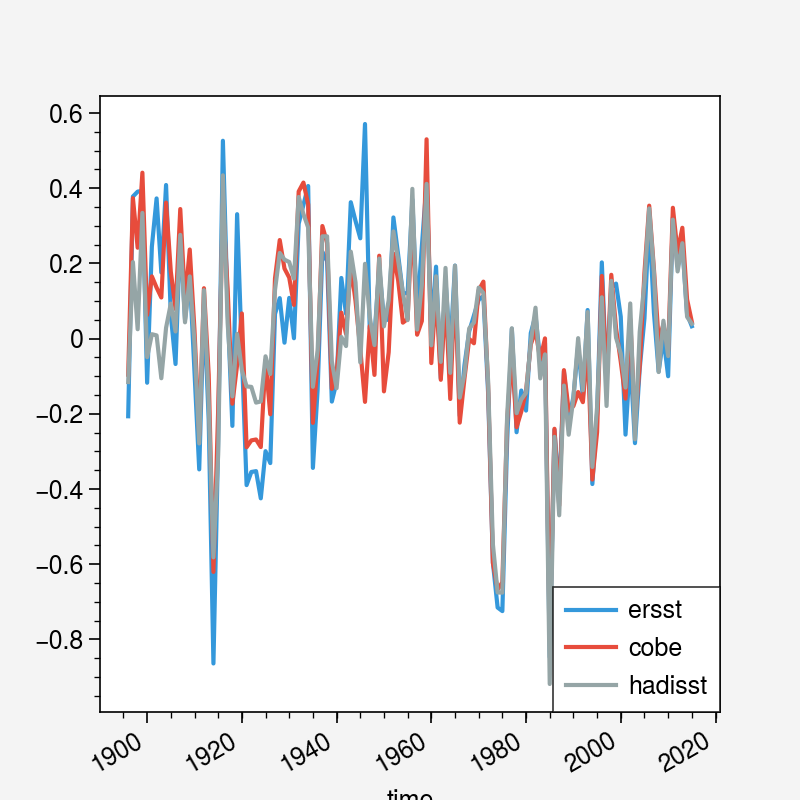

In [6]:
for key in obsdsst.keys():
    
    obsdsst[key].plot(label=key)
plt.legend()

## AMV

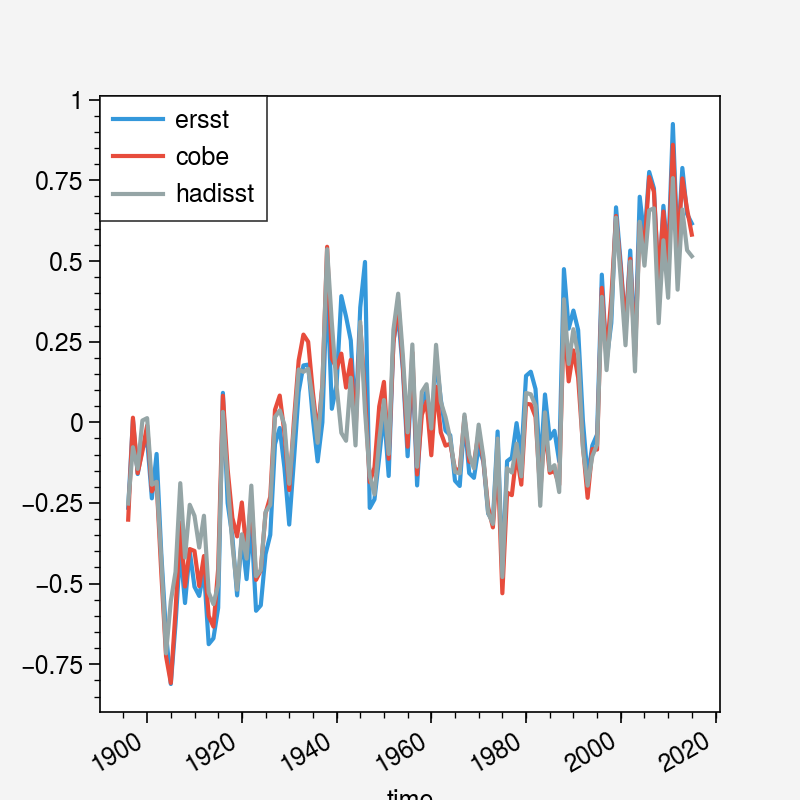

In [7]:
for key in obsamv.keys():
    
    obsamv[key].plot(label=key)
plt.legend()

## SPR

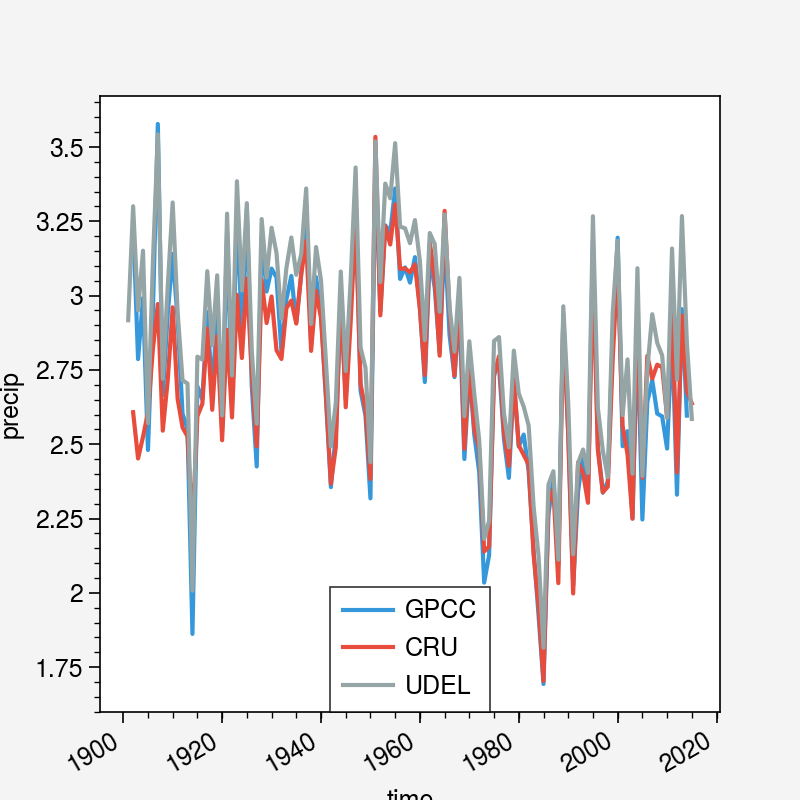

In [8]:
for key in obsprecp.keys():
    obsprecp[key].plot(label=key)
plt.legend()


## VWS

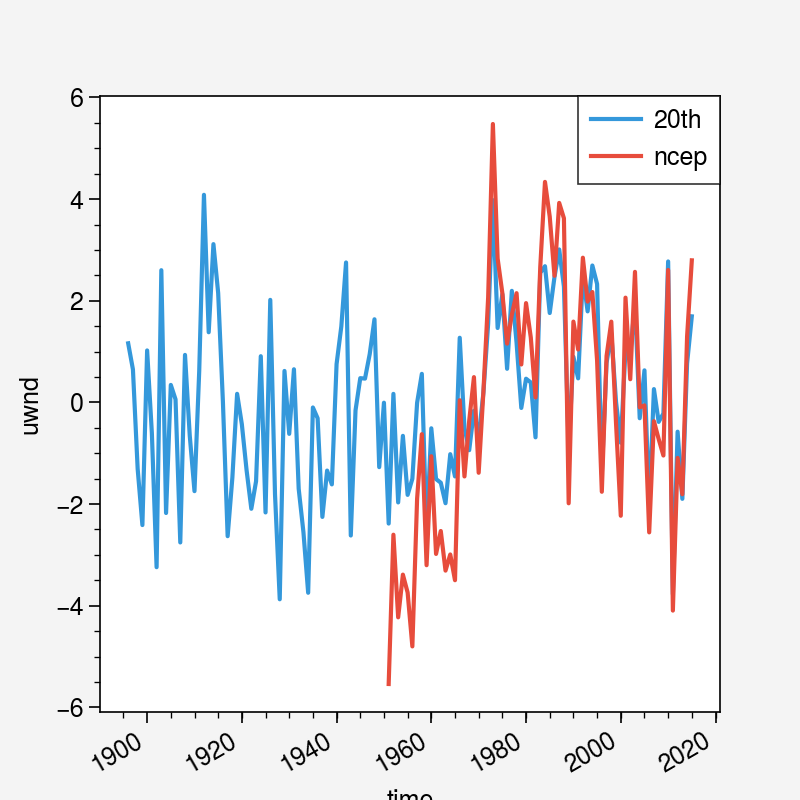

In [9]:
for key in obsvws.keys():
    obsvws[key].plot(label=key)
plt.legend()


In [10]:
obsdsst = xr.Dataset(obsdsst)
obsamv = xr.Dataset(obsamv)
obsprecp = xr.Dataset(obsprecp)
obsvws = xr.Dataset(obsvws)
# obsprecp = obsprecp.interpolate_na(dim='time', fill_value="extrapolate") # fix 1900
obsprecp = obsprecp.sel(time=slice('1901', '2013')) # fix 1900

# Model simulation

In [11]:
def detrend_lowpass_filter(ds):
    # return ds.stat.detrend(ds.time.dt.year).stat.filter_butter(dt=1, band=10).stat.normalize()
    return ds.stat.detrend(ds.time.dt.year).stat.filter_butter(dt=1, band=10)
    # return ds.stat.detrend(ds.time.dt.year).stat.filter_butter(dt=1, band=10)

def detrend(ds):
    # return ds.stat.detrend(ds.time.dt.year).stat.normalize()
    return ds.stat.detrend(ds.time.dt.year)

def corr(ds0, ds1):
    return ds0.stat.corr_with(ds1)

def lowpass_filter(ds):
    # return ds.stat.detrend(ds.time.dt.year).stat.normalize()
    return ds.stat.filter_butter(dt=1, band=10)
    # return ds.rolling(time=5, center=True).mean()

In [12]:
amv = xr.open_dataarray('0temp_data/gs.CMIP6.historical.AMV.JJASO.pub.pre1950.nc').convert_calendar('gregorian')
vws = xr.open_dataarray('0temp_data/gs.CMIP6.historical.VWS.JJASO.pub1.nc').convert_calendar('gregorian')
spr = xr.open_dataarray('0temp_data/gs.CMIP6.historical.Sahel-pr.JJASO.pub.pre1950.nc').convert_calendar('gregorian') * 86400
dsst = xr.open_dataarray('0temp_data/gs.CMIP6.historical.dSST.JJASO-annual.pub2.pre1950.nc').convert_calendar('gregorian')
ds = xr.merge([amv.rename('amv'),  vws.rename('vws'), spr.rename('spr'), dsst.rename('dsst')], join='inner')

In [13]:
amv = xr.open_dataarray('0temp_data/gs.CMIP6.historical.AMV.JJASO.pub.nc').convert_calendar('gregorian')
vws = xr.open_dataarray('0temp_data/gs.CMIP6.historical.VWS.JJASO.pub1.nc').convert_calendar('gregorian')
spr = xr.open_dataarray('0temp_data/gs.CMIP6.historical.Sahel-pr.JJASO.pub.nc').convert_calendar('gregorian') * 86400
dsst = xr.open_dataarray('0temp_data/gs.CMIP6.historical.dSST.JJASO-annual.pub2.nc').convert_calendar('gregorian')
ds1 = xr.merge([amv.rename('amv'), vws.rename('vws'), spr.rename('spr'), dsst.rename('dsst')], join='inner')

In [14]:
dd = ds1.sel(time='1950') - ds.sel(time='1950')

In [15]:
# 1900-2014

In [16]:
ds = xr.concat([ds+dd.squeeze().drop('time'), 
                ds1.sel(time=slice('1951','2014'))], dim='time')

obsdsst = obsdsst.sel(time=slice('1900','2014'))
obsamv = obsamv.sel(time=slice('1900','2014'))
obsprecp = obsprecp.sel(time=slice('1900','2014'))
obsvws = obsvws.sel(time=slice('1900','2014'))


In [17]:

dsm = ds.mean('mb')
dsml = dsm.map(lowpass_filter) 
dsl = ds.map(lowpass_filter) 

dsmld = dsml
dsld = dsl

In [18]:
dsmld = dsmld - dsmld.mean('time')
dsml = dsml - dsml.mean('time')

dsl = dsl - dsl.mean('time')

In [19]:
obsdsstl = obsdsst.map(lowpass_filter)
obsamvl = obsamv.map(lowpass_filter)
obsvwsl = obsvws.map(lowpass_filter)
obsprecpl = obsprecp.map(lowpass_filter)

obsdsstl = obsdsstl - obsdsstl.mean('time')
obsamvl = obsamvl - obsamvl.mean('time')
obsvwsl = obsvwsl - obsvwsl.mean('time')
obsprecpl = obsprecpl - obsprecpl.mean('time')



In [20]:
time=slice('1905','1950')
obsdsstld = obsdsstl.sel(time=time)
obsamvld = obsamvl.sel(time=time)
obsvwsld = obsvwsl.sel(time=time)
obsprecpld = obsprecpl.sel(time=time)

dsmld = dsmld.sel(time=time)
dsld = dsld.sel(time=time)


In [21]:
# corr
def corr(ds0):
     
    c_amv_spr = ds0.amv.stat.corr_with(ds0.spr).rename('c_amv_spr')
    c_amv_vws = ds0.amv.stat.corr_with(ds0.vws).rename('c_amv_vws')
    
    c_dsst_spr = ds0.dsst.stat.corr_with(ds0.spr).rename('c_dsst_spr')
    c_dsst_vws = ds0.dsst.stat.corr_with(ds0.vws).rename('c_dsst_vws')
    
    return xr.merge([c_amv_spr, c_amv_vws, c_dsst_spr, c_dsst_vws])
    

    
def corr_obs(ds0, ds1):
    
    TMP = []
    for k0 in ds0.keys():
        for k1 in ds1.keys():
            tmp = ds0[k0].stat.corr_with(ds1[k1]).assign_coords(i=k0+k1)
            TMP.append(tmp)
    return xr.concat(TMP, dim='i')
            

time = slice('1905', '1950') # remove end point in filtering
r_mb = corr(dsld.sel(time=time))

r_em = corr(dsmld.sel(time=time))


ob_amv_vws1 = corr_obs(obsamvld, obsvwsld[['20th']])
ob_amv_spr1 = corr_obs(obsamvld, obsprecpld)

ob_dsst_vws1 = corr_obs(obsdsstld, obsvwsld[['20th']])
ob_dsst_spr1 = corr_obs(obsdsstld, obsprecpld)


ob_amv_vws = ob_amv_vws1.mean('i')
ob_amv_spr = ob_amv_spr1.mean('i')
ob_dsst_vws = ob_dsst_vws1.mean('i')
ob_dsst_spr = ob_dsst_spr1.mean('i')



ob_amv_vws1 = xr.concat([ob_amv_vws1, ob_amv_vws1, ob_amv_vws1], dim='i').sortby('i')
ob_amv_spr1 = ob_amv_spr1.sortby('i')

ob_dsst_vws1 = xr.concat([ob_dsst_vws1, ob_dsst_vws1, ob_dsst_vws1], dim='i').sortby('i')
ob_dsst_spr1 = ob_dsst_spr1.sortby('i')

(-1.0, 0.5)

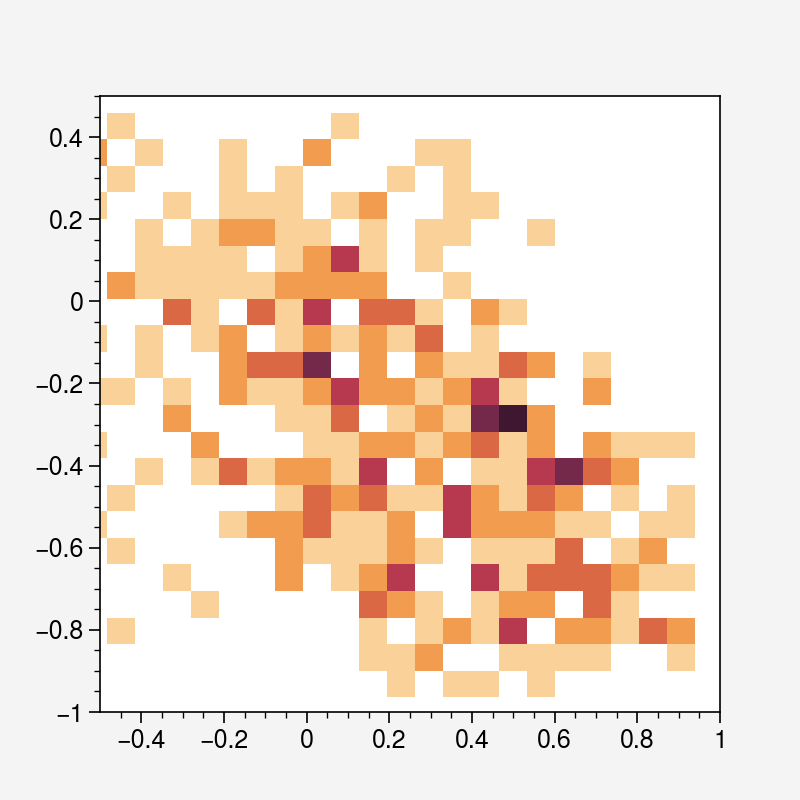

In [22]:
corr1 = xr.merge([r_mb.c_amv_spr.rename('amv_spr'),
                 r_mb.c_amv_vws.rename('amv_vws')]).dropna('mb')

hhp1 = plt.hist2d(corr1.amv_spr, corr1.amv_vws, bins=25)
plt.xlim([-0.5, 1])
plt.ylim([-1, 0.5])

(-1.0, 0.5)

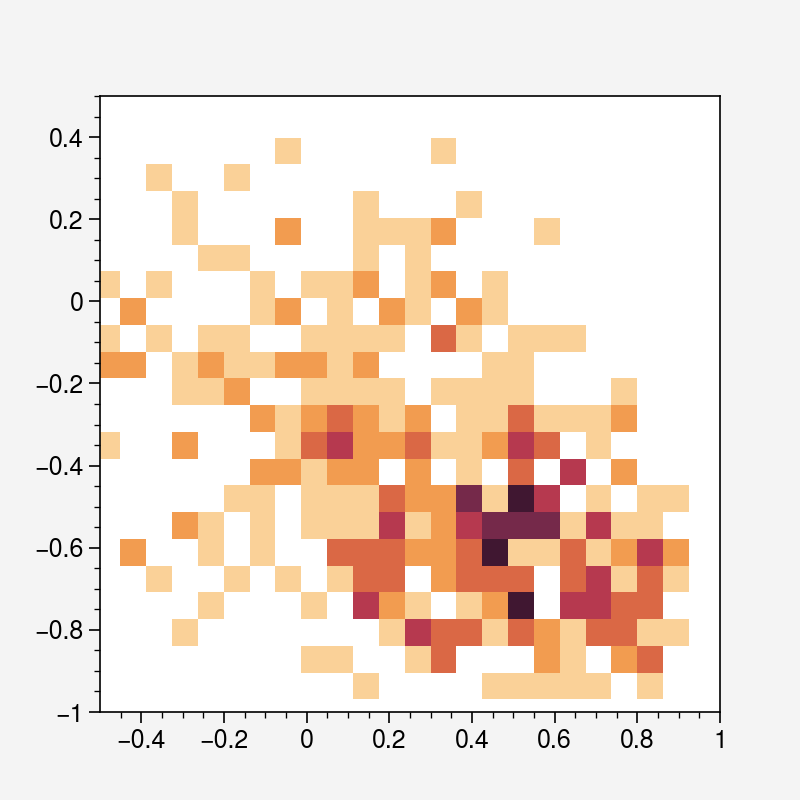

In [23]:
corr2 = xr.merge([r_mb.c_dsst_spr.rename('dsst_spr'),
                 r_mb.c_dsst_vws.rename('dsst_vws')]).dropna('mb')

hhp2 = plt.hist2d(corr2.dsst_spr, corr2.dsst_vws, bins=25)
plt.xlim([-0.5, 1])
plt.ylim([-1, 0.5])

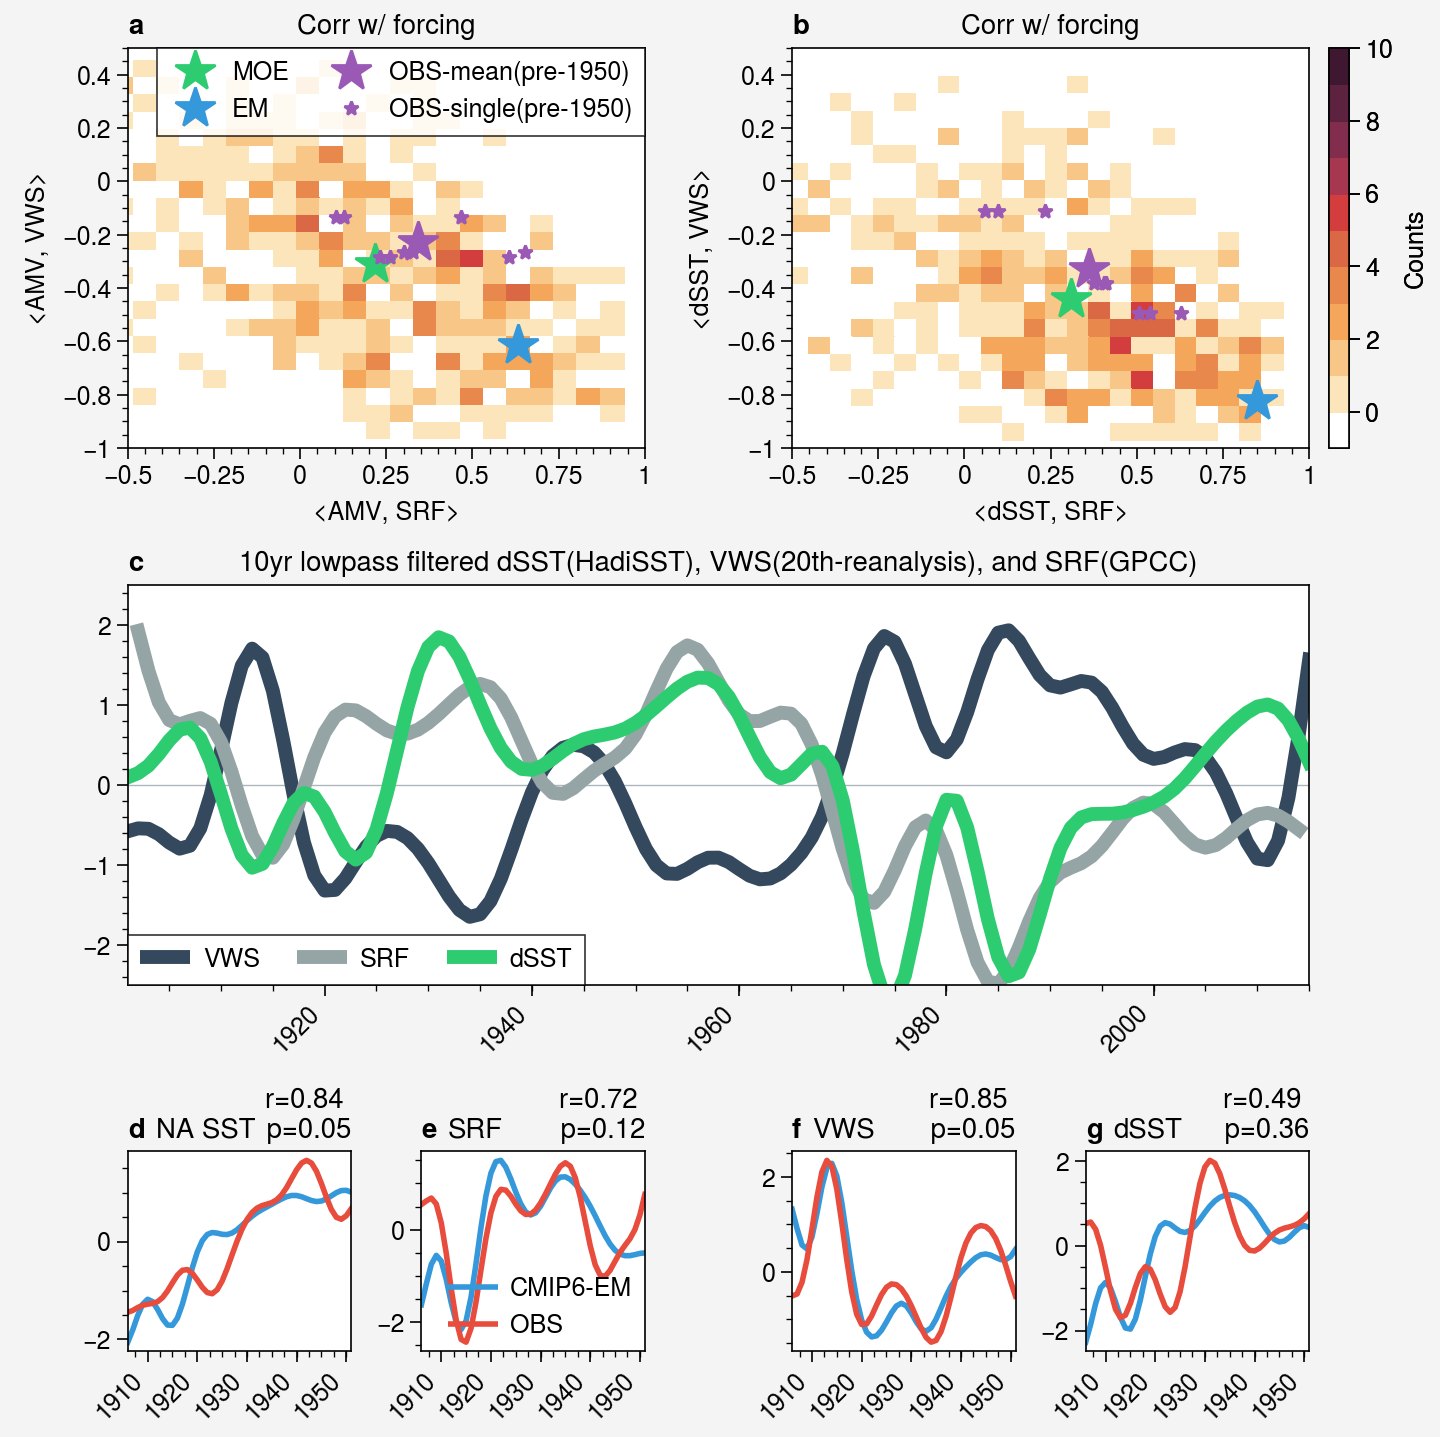

In [26]:
layout = [
    [1,1, 2,2],
    [1,1, 2,2],
    [3,3, 3, 3],      
    [3,3, 3, 3],      
     [4, 5, 6, 7] ]
fig, axs = pplt.subplots(layout, sharey=False, sharex=False, 
                          refnum=5, refwidth=2, refheight=1, journal='nat2', )#wratios= [1, 1, 1, 1, 1, 1], hratios=[1, 1],hratios=[1, 1, 1], wratios= [1, 1, 1, 1, 1, 1]


#### distribution
lev = np.arange(-1, 10.1, 1)
m = axs[0].pcolor(hhp1[1], hhp1[2], hhp1[0].T, levels = lev, extend='neither')
m = axs[1].pcolor(hhp2[1], hhp2[2], hhp2[0].T, levels = lev, extend='neither')
axs[1].colorbar(m, loc='r', width=0.1, ticks=lev[1::2], label='Counts')

axs[0].plot(r_mb.c_amv_spr.mean(), r_mb.c_amv_vws.mean(), '*', ms=15, label='MOE', c='C4')
axs[1].plot(r_mb.c_dsst_spr.mean(), r_mb.c_dsst_vws.mean(), '*', ms=15, label='MOE', c='C4')

axs[0].plot(ob_amv_spr, ob_amv_vws, '*', ms=15, label='OBS-mean(pre-1950)', c='C5')
axs[1].plot(ob_dsst_spr, ob_dsst_vws, '*', ms=15, label='OBS(pre-1950)', c='C5')

axs[0].plot(r_em.c_amv_spr, r_em.c_amv_vws, '*', ms=15, label='EM', c='C0')
axs[1].plot(r_em.c_dsst_spr, r_em.c_dsst_vws, '*', ms=15, label='EM', c='C0')


axs[0].plot(ob_amv_spr1, ob_amv_vws1, '*', ms=5, c='C5', label='OBS-single(pre-1950)',)
axs[1].plot(ob_dsst_spr1, ob_dsst_vws1, '*', ms=5, c='C5', label='OBS-single(pre-1950)',)

#### time series

obsvwsl['20th'].stat.normalize().plot(ax=axs[2], lw=5, c='C3', label='VWS')
obsprecpl.GPCC.stat.normalize().plot(ax=axs[2], lw=5, c='C2', label='SRF')
obsdsstl.hadisst.stat.normalize().plot(ax=axs[2], lw=5, c='C4', label='dSST')


#### AMV, SPR, VWS, dSST
dsmld.amv.stat.normalize().plot(ax=axs[3], lw=2, label='CMIP6-EM')
obsamvld.ersst.stat.normalize().plot(ax=axs[3], lw=2, label='OBS')

dsmld.spr.stat.normalize().plot(ax=axs[4], lw=2, label='CMIP6-EM')
obsprecpld.GPCC.stat.normalize().plot(ax=axs[4], lw=2, label='OBS')

dsmld.vws.stat.normalize().plot(ax=axs[5], lw=2, label='CMIP6-EM')
obsvwsld['20th'].stat.normalize().plot(ax=axs[5], lw=2, label='OBS')

dsmld.dsst.stat.normalize().plot(ax=axs[6], lw=2, label='CMIP6-EM')
obsdsstld.hadisst.stat.normalize().plot(ax=axs[6], lw=2, label='OBS')



axs[0:2].format(xlim=[-0.5, 1], ylim=[-1, 0.5])
axs[0].format(xlabel='<AMV, SRF>', ylabel='<AMV, VWS>', title='Corr w/ forcing')
axs[1].format(xlabel='<dSST, SRF>', ylabel='<dSST, VWS>', title='Corr w/ forcing')
axs[0].legend(ncols=2)
axs[2::].format(xrotation=45, xlabel='')
axs[2].hlines(0, obsdsstl.time.min(), obsdsstl.time.max(), c='gray5', lw=0.5)
axs[2].legend()
axs[2].format(ylabel='', ylim=[-2.5, 2.5], xlabel='',
              title='10yr lowpass filtered dSST(HadiSST), VWS(20th-reanalysis), and SRF(GPCC)')

# axs[3::].format(ylabel='', xlocator=obsdsstld.time[5::10].values)
axs[3::].format(ylabel='', xlim=[dsmld.time.min(), dsmld.time.max()], 
                xlocator=('year', 10),
               xformatter='%Y')
axs[3].format(ltitle='NA SST', rtitle='r=0.84 \n p=0.05')
axs[4].format(ltitle='SRF', rtitle='r=0.72 \n p=0.12')
axs[5].format(ltitle='VWS', rtitle='r=0.85 \n p=0.05')
axs[6].format(ltitle='dSST', rtitle='r=0.49 \n p=0.36')
axs[4].legend(frame=False, ncols=1)
axs.format(abc=True)

plt.savefig('1pfigs/r1.fig4.pdf')

In [25]:
print(dsmld.amv.stat.corr_with(obsamvld.hadisst, statistical_test=True,dof=3.5))
print(dsmld.spr.stat.corr_with(obsprecpld.GPCC, statistical_test=True,dof=3.5))
print(dsmld.vws.stat.corr_with(obsvwsld['20th'], statistical_test=True,dof=3.5))
print(dsmld.dsst.stat.corr_with(obsdsstld.hadisst, statistical_test=True,dof=3.5))

(<xarray.DataArray 'r' ()>
array(0.84254102)
Attributes:
    units:        unitless
    Description:  Pearson Correlation Coefficients between amv and hadisst., <xarray.DataArray 'pval' ()>
array(0.05062436))
(<xarray.DataArray 'r' ()>
array(0.72815145)
Attributes:
    units:        unitless
    Description:  Pearson Correlation Coefficients between spr and GPCC., <xarray.DataArray 'pval' ()>
array(0.12782769))
(<xarray.DataArray 'r' ()>
array(0.84997259)
Attributes:
    units:        unitless
    Description:  Pearson Correlation Coefficients between vws and 20th., <xarray.DataArray 'pval' ()>
array(0.04660437))
(<xarray.DataArray 'r' ()>
array(0.48665019)
Attributes:
    units:        unitless
    Description:  Pearson Correlation Coefficients between dsst and hadisst., <xarray.DataArray 'pval' ()>
array(0.36389625))
